In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nf, r_in, r_out = (3, 1, 2)
organo = create_organo(nf, r_in, r_out)
print(organo.vert_df.loc[:, ('x', 'y')])

organo.edge_df.loc[:nf, 'line_tension'] *= 2
organo.edge_df.loc[nf:2*nf-1, 'line_tension'] = 0
geom.update_all(organo)

Reseting datasets values with new specs


             x             y
vert                        
0     0.277926 -4.813825e-01
1    -0.555853  6.807231e-17
2     0.277926  4.813825e-01
3     0.555853 -9.627649e-01
4    -1.111705  1.361446e-16
5     0.555853  9.627649e-01


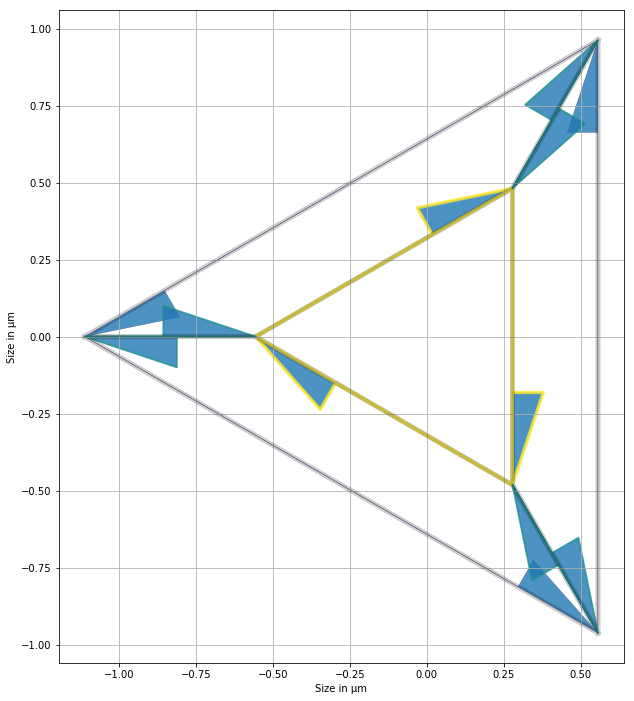

In [3]:
print_tensions(organo, organo)

In [4]:
organo.edge_df.line_tension

edge
0     0.002
1     0.002
2     0.002
3     0.000
4     0.000
5     0.000
6     0.001
7     0.001
8     0.001
9     0.001
10    0.001
11    0.001
Name: line_tension, dtype: float64

In [5]:
organo.face_df.prefered_area - organo.face_df.area

face
0    0.0
1    0.0
2    0.0
dtype: float64

In [6]:
from tyssue_taylor.adjusters.force_inference import _coef_matrix
matrix = _coef_matrix(organo, sup_param='areas')

## Matrice sans modification

In [7]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
nnls(matrix, constant)

(array([0.00035385, 0.00035385, 0.        , 0.        , 0.        ,
        0.00028308, 0.00085805, 0.00122579, 0.00085805, 0.00127319,
        0.00127319, 0.00101855, 0.        ]), 4.763187937278114e-19)

## Matrice avec le bon facteur d'échelle

In [8]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
constant[-1] = 0.009
nnls(matrix, constant)

(array([0.0008098 , 0.0008098 , 0.        , 0.        , 0.        ,
        0.00064784, 0.00196366, 0.00280523, 0.00196366, 0.00291373,
        0.00291373, 0.00233098, 0.        ]), 1.566299283139904e-18)

## Les lignes de A ne sont pas indépendantes

Il est possible d'exprimer les lignes 0 et 6 comme des combinaisons linéaires des lignes 1 à 5 et 7 à 11, respectivement.

In [9]:
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 8.66025404e-01,  0.00000000e+00, -4.61264420e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.00000000e-01,  0.00000000e+00,
        0.00000000e+00, -4.81382468e-01,  0.00000000e+00,  7.22073702e-01,
       -4.81382468e-02])

In [10]:
-matrix[0]

array([ 8.66025404e-01, -0.00000000e+00, -4.61264420e-16, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -5.00000000e-01, -0.00000000e+00,
       -0.00000000e+00, -4.81382468e-01, -0.00000000e+00,  7.22073702e-01,
       -4.81382468e-02])

In [11]:
matrix[7]+matrix[8]+matrix[9]+matrix[10]+matrix[11]

array([-0.5       ,  0.        , -1.        ,  0.        ,  0.        ,
        0.        ,  0.8660254 ,  0.        ,  0.        , -0.5558526 ,
        0.        ,  0.13896315,  0.08337789])

In [12]:
-matrix[6]

array([-0.5       , -0.        , -1.        , -0.        , -0.        ,
       -0.        ,  0.8660254 , -0.        , -0.        , -0.5558526 ,
       -0.        ,  0.13896315,  0.08337789])

## Matrice avec la dernière ligne "splitée" en trois contraintes
On supprime la contrainte $$\sum \Lambda_{i,j} = c$$ On ajoute les contraintes $$\Lambda_0 + \Lambda_1 + \Lambda_2 = c_1$$ $$\Lambda_3 + \Lambda_4 + \Lambda_5 = c_2$$ $$\Lambda_6 + \Lambda_7 + \Lambda_8 = c_3$$ Où $c_1+c_2+c_3=c$

In [13]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0, 0.003]))
matrix = _coef_matrix(organo, sup_param='areas')
matrix[-1] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
matrix = np.vstack((matrix,
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))
nnls(matrix, constant)

(array([0.002     , 0.002     , 0.002     , 0.        , 0.        ,
        0.        , 0.001     , 0.001     , 0.001     , 0.00103868,
        0.00103868, 0.00103868, 0.03078739]), 9.606895934580462e-19)

## Matrice avec la dernière ligne "splitée" en deux contraintes
On constate qu'il suffit d'ajouter deux contraintes pour obtenir le résultat attendu.

In [14]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0]))
matrix = _coef_matrix(organo, sup_param='areas')
matrix[-1] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
matrix = np.vstack((matrix,
                    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]))
nnls(matrix, constant)

(array([2.00000000e-03, 2.00000000e-03, 2.00000000e-03, 3.77569963e-19,
        1.47448659e-19, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.22215906e-19, 2.33931461e-19, 2.56365192e-19,
        3.59807621e-02]), 4.065564799163062e-19)

## Résolution pour les sommets 0 et 3

In [15]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix) # [[0, 3, 6, 9, 12]]
constant[-1] = organo.edge_df.line_tension[[0, 2, 9]].sum()
matrix = matrix[:, [0, 2, 3, 5, 6, 9, 11, 12]]
#matrix = matrix[[0, 3, 6, 9, 12], :]
print(matrix)
nnls(matrix, constant)

[[-8.66025404e-01  4.61264420e-16  0.00000000e+00  0.00000000e+00
   5.00000000e-01  4.81382468e-01 -7.22073702e-01  4.81382468e-02]
 [ 8.66025404e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.40691234e-01  0.00000000e+00 -9.62764936e-02]
 [ 0.00000000e+00 -4.61264420e-16  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -7.22073702e-01  4.81382468e-02]
 [ 0.00000000e+00  0.00000000e+00 -8.66025404e-01  4.61264420e-16
  -5.00000000e-01 -2.40691234e-01  7.22073702e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.66025404e-01  0.00000000e+00
   0.00000000e+00 -4.81382468e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.61264420e-16
   0.00000000e+00  0.00000000e+00  7.22073702e-01  0.00000000e+00]
 [ 5.00000000e-01  1.00000000e+00  0.00000000e+00  0.00000000e+00
  -8.66025404e-01  5.55852595e-01 -1.38963149e-01 -8.33778893e-02]
 [-5.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

(array([0.00172077, 0.00172077, 0.        , 0.        , 0.00129393,
        0.00079996, 0.00079996, 0.01882483]), 0.001150060395382562)

## Matrice avec deux contraintes d'égalité
Ici on pose les contraintes $\Lambda_1 = \Lambda_2$ et $\Lambda_6 = \Lambda_7$

In [16]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)
constant[-1] = 0.009
constant = np.concatenate((constant, [0, 0]))
matrix = np.vstack((matrix,
                    [0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0]))
nnls(matrix, constant)

(array([6.72027713e-04, 6.72027713e-04, 6.72027713e-04, 0.00000000e+00,
        7.88465262e-19, 0.00000000e+00, 2.32797229e-03, 2.32797229e-03,
        2.32797229e-03, 2.41800693e-03, 2.41800693e-03, 2.41800693e-03,
        0.00000000e+00]), 1.5354533045537508e-18)

## Matrice avec les pressions

In [17]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='pressions')
constant = _right_side(organo, matrix)
constant[-1] = 0.009
nnls(matrix, constant)

AssertionError: 
            Inconsistent partition:
            total half-edges: 12
            number of free: 6
            number of east: 2
            number of west: 2

In [18]:
def _pression_coefs(organo, no_scale):
    beta_x = 0.5*organo.edge_df.dy[:3*organo.Nf].copy()
    beta_y = -0.5*organo.edge_df.dx[:3*organo.Nf].copy()
    # cell to cell coefficients are placed on 4 stacked diagonal matrix
    coef_lat_pres = np.vstack((
        np.diag(beta_x[np.intersect1d(np.arange(3*organo.Nf),
                                      organo.lateral_edges.values)]),
        -np.diag(beta_x[np.intersect1d(np.arange(3*organo.Nf),
                                       organo.lateral_edges.values)]),
        np.diag(beta_y[np.intersect1d(np.arange(3*organo.Nf),
                                      organo.lateral_edges.values)]),
        -np.diag(beta_y[np.intersect1d(np.arange(3*organo.Nf),
                                       organo.lateral_edges.values)])))
    coef_api_pres = np.concatenate((
        np.add(beta_x[organo.apical_edges],
               np.roll(beta_x[organo.apical_edges], 1)),
        np.zeros(organo.Nf),
        np.add(beta_y[organo.apical_edges],
               np.roll(beta_y[organo.apical_edges], 1)),
        np.zeros(organo.Nf)))
    # exterior to cell coefficients in a columnar vector
    coef_bas_pres = np.concatenate((
        np.zeros(organo.Nf),
        np.add(beta_x[organo.basal_edges],
               np.roll(beta_x[organo.basal_edges], 1)),
        np.zeros(organo.Nf),
        np.add(beta_y[organo.basal_edges],
               np.roll(beta_y[organo.basal_edges], 1))))
    coef_bas_pres = np.zeros(coef_bas_pres.shape)
    pres_coef = np.hstack((coef_lat_pres,
                           np.reshape(coef_api_pres, (2*organo.Nv, 1)),
                           np.reshape(coef_bas_pres, (2*organo.Nv, 1))))
    if not no_scale:
        pres_coef = np.vstack((pres_coef, np.zeros(organo.Nf+2)))
    return pres_coef

On conserve la symétrie mais on n'obtient pas le résultat attendu.

In [19]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='')
matrix = np.hstack((matrix, _pression_coefs(organo, False)))
constant = _right_side(organo, matrix)
constant[-1] = 0.009
nnls(matrix, constant)

(array([1.18301270e-03, 1.18301270e-03, 1.18301270e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.50000000e-03, 1.50000000e-03,
        1.50000000e-03, 2.65862322e-18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]), 0.002925518253046813)

Remarque : les relations entre les lignes de A sont conservées avec les coefficients des pressions

In [20]:
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 8.66025404e-01,  0.00000000e+00, -4.61264420e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -5.00000000e-01,  0.00000000e+00,
        0.00000000e+00, -2.40691234e-01,  0.00000000e+00,  0.00000000e+00,
        2.40691234e-01,  0.00000000e+00])

In [21]:
-matrix[0]

array([ 8.66025404e-01, -0.00000000e+00, -4.61264420e-16, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -5.00000000e-01, -0.00000000e+00,
       -0.00000000e+00, -2.40691234e-01, -0.00000000e+00, -0.00000000e+00,
        2.40691234e-01, -0.00000000e+00])

In [22]:
matrix[7]+matrix[8]+matrix[9]+matrix[10]+matrix[11]

array([-0.5       ,  0.        , -1.        ,  0.        ,  0.        ,
        0.        ,  0.8660254 ,  0.        ,  0.        , -0.13896315,
        0.        ,  0.        , -0.41688945,  0.        ])

In [23]:
-matrix[6]

array([-0.5       , -0.        , -1.        , -0.        , -0.        ,
       -0.        ,  0.8660254 , -0.        , -0.        , -0.13896315,
       -0.        , -0.        , -0.41688945, -0.        ])

L'ajout de contraintes supplémentaires ne permet pas d'obtenir le résultat attendu mais on conserve toujours la symétrie.

In [24]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='')
matrix = np.hstack((matrix, _pression_coefs(organo, False)))
constant = _right_side(organo, matrix)
constant[-1] = 0.006
constant = np.concatenate((constant, [0, 0.003, 0]))
matrix[-1] = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
matrix = np.vstack((matrix,
                    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))
nnls(matrix, constant)

(array([1.30356120e-03, 1.30356120e-03, 1.30356120e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.05156685e-03, 1.05156685e-03,
        1.05156685e-03, 1.40750641e-18, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]), 0.003474449131837232)

In [25]:
matrix

array([[-8.66025404e-01,  0.00000000e+00,  4.61264420e-16,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         5.00000000e-01,  0.00000000e+00,  0.00000000e+00,
         2.40691234e-01,  0.00000000e+00,  0.00000000e+00,
        -2.40691234e-01,  0.00000000e+00],
       [ 8.66025404e-01,  8.66025404e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.40361551e-17,  0.00000000e+00,
         4.81382468e-01,  0.00000000e+00],
       [ 0.00000000e+00, -8.66025404e-01, -4.61264420e-16,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  5.00000000e-01,
         0.00000000e+00,  0.00000000e+00, -2.40691234e-01,
        -2.40691234e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -8.66025404e-01,  0.00000000e+00,  4.61264420e-16,
        -5.00000000e-01,  0.00000000e+00,  0.